In [52]:
import numpy as np
from personas import personas
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def extract_id(string):
    tokens = string.split()
    id = tokens[0]
    text = " ".join(tokens[1:])
    return id, text

In [3]:
with open("P11-1076.Datasets/data/raw/questions") as f:
    questions = f.readlines()
idx_to_qid = [extract_id(q)[0] for q in questions]
qid_to_idx = {q: i for i, q in enumerate(idx_to_qid)}

In [4]:
idx_to_pid = list(personas.keys())
pid_to_idx = {p: i for i, p in enumerate(idx_to_pid)}

In [37]:
base_df = pd.read_json("p1_0.jsonl", lines=True)
cond_df = pd.read_json("p1_1.jsonl", lines=True)

In [38]:
assert(base_df["completion"].dtype == float)
assert(cond_df["completion"].dtype == float)

In [72]:
def read_to_float(filename):
    with open(filename) as f:
        lines = f.readlines()
        lines = [float(l.strip()) for l in lines]
    return lines

def create_from_files(src_dir, q_id):
    dir = src_dir + q_id + "/"
    me = read_to_float(dir + "me")
    other = read_to_float(dir + "other")
    ave = read_to_float(dir + "ave")

    assert(len(me) == len(other))
    assert(len(other) == len(ave))

    dicts = []
    for i in range(len(me)):
        dicts.append({
            "q_id": float(q_id),
            "r_idx": i,
            "me": me[i],
            "other": other[i],
            "ave": ave[i],
        })
    return dicts

scores_dir = "P11-1076.Datasets/data/scores/"
human_entries = []
for q_id in idx_to_qid:
    human_entries += create_from_files(scores_dir, q_id)

In [73]:
hum_df = pd.DataFrame.from_records(human_entries)
hum_df["completion"] = hum_df["ave"]

In [50]:
hum_df.describe()

,r_idx,me,other,ave
count,2442.000000,2442.000000,2442.000000,2442.000000
mean,13.605651,4.843161,5.457617,4.190571
std,8.219322,2.644352,2.228899,1.112038
min,0.000000,0.000000,0.000000,0.000000
25%,7.000000,3.000000,4.000000,3.500000
50%,14.000000,5.000000,5.000000,5.000000
75%,21.000000,5.000000,5.000000,5.000000
max,30.000000,10.000000,10.000000,5.000000


In [51]:
base_df.describe()

,q_id,r_idx,p_id,completion
count,2442.000000,2442.000000,2442.0,2442.000000
mean,7.202211,13.605651,1.0,3.139025
std,3.688497,8.219322,0.0,1.741316
min,1.100000,0.000000,1.0,0.000000
25%,3.700000,7.000000,1.0,2.000000
50%,7.400000,14.000000,1.0,3.000000
75%,10.600000,21.000000,1.0,5.000000
max,12.900000,30.000000,1.0,5.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x15c4eeca2c0>,
 'caps': [<matplotlib.lines.Line2D at 0x15c4eeca800>,
 'boxes': [<matplotlib.lines.Line2D at 0x15c4eeca020>,
 'medians': [<matplotlib.lines.Line2D at 0x15c4eecad40>,
 'fliers': [<matplotlib.lines.Line2D at 0x15c4eecb010>,
 'means': []}

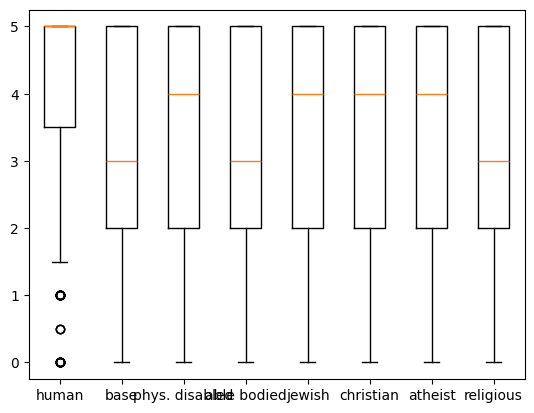

In [60]:
cond_data = [cond_df[cond_df["persona_id"] == p_id]["completion"] for p_id in [1.0, 1.1, 2.0, 2.1, 2.2, 2.3]]
plt.boxplot([hum_df["ave"], base_df["completion"]] + cond_data, 
    labels=["human", "base", "phys. disabled", "able bodied", "jewish", "christian", "atheist", "religious"])

In [74]:
def score_diff(first_df, second_df, q_id=None, r_idx=None):
    qs = idx_to_qid if q_id is None else [q_id]
    diff = 0
    for q in qs:
        first = first_df[first_df["q_id"] == float(q)]
        second = second_df[second_df["q_id"] == float(q)]
        if r_idx is None:
            for r in first["r_idx"]:
                diff += first[first["r_idx"] == r]["completion"].iloc[0] - second[second["r_idx"] == r]["completion"].iloc[0]
        else:
            diff += first[first["r_idx"] == r_idx]["completion"].iloc[0] - second[second["r_idx"] == r_idx]["completion"].iloc[0]
    return diff

<BarContainer object of 7 artists>

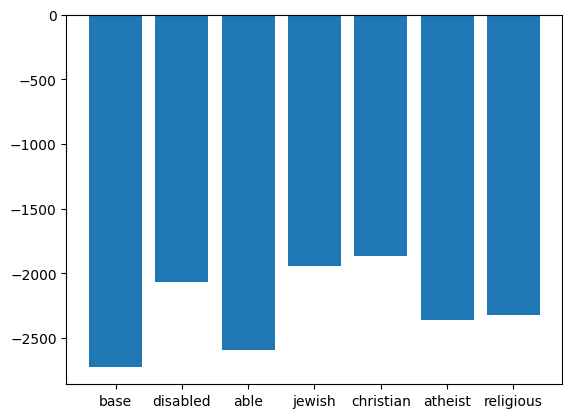

In [77]:
cond_compare = [cond_df[cond_df["persona_id"] == p_id] for p_id in [1.0, 1.1, 2.0, 2.1, 2.2, 2.3]]
to_compare = [base_df] + cond_compare

plt.bar(["base", "disabled", "able", "jewish", "christian", "atheist", "religious"],
        [score_diff(df, hum_df) for df in to_compare])

<BarContainer object of 6 artists>

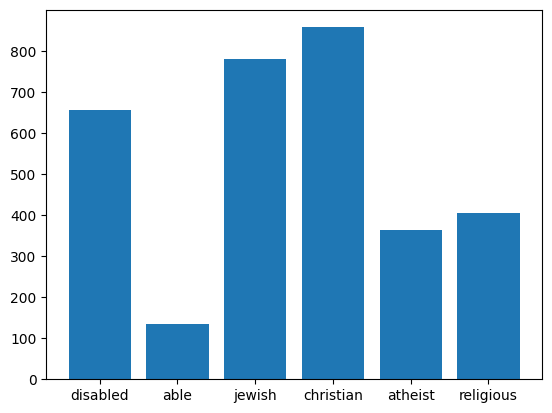

In [78]:
plt.bar(["disabled", "able", "jewish", "christian", "atheist", "religious"],
        [score_diff(df, base_df) for df in cond_compare])